# Benchmarking the scANVI fix

As of the scvi-tools 1.1.0 release, we have included a critical bug fix for [scANVI](https://docs.scvi-tools.org/en/stable/user_guide/models/scanvi.html), which is used for semi-supervised modeling of single-cell transcriptomics data.  In previous versions, the classifier portion of the model incorrectly treated logits outputs as probabilities, generally leading to the following consequences:

- Increased number of training epochs required for the convergence of the classification loss
- Accuracy, F1 score, and calibration error indicative of a poorly performing classifier
- Inferior performance in label transferring to query data
- Latent space with conservation of cell-type variability

Users may refer to the corresponding [pull request](https://github.com/scverse/scvi-tools/pull/2301) for more details about the fix. 

In this tutorial, we use the data and preprocessing steps in [Atlas-level integration of lung data](https://docs.scvi-tools.org/en/latest/tutorials/notebooks/scrna/harmonization.html), while comparing the previous and fixed models. In addition to these, we include in our comparison a version of the fixed model with a simpler, linear classifier. We hypothesize that the previous (more complex) MLP classifier was necessary since the model specification was incorrect.

## Imports and downloading data

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/usr/local/lib/python3.12/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [1]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scib_metrics.benchmark import Benchmarker

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing CSRD

In [2]:
scvi.settings.seed = 0
print("Last run with scvi-tools version", scvi.__version__)

Seed set to 0


Last run with scvi-tools version 1.2.1


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [3]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

Note that this dataset has the counts already separated in a layer. Here, `adata.X` contains log transformed scran normalized expression.

In [4]:
adata_path = os.path.join(save_dir.name, "lung_atlas.h5ad")

adata = sc.read(
    adata_path,
    backup_url="https://figshare.com/ndownloader/files/24539942",
)
adata

  0%|          | 0.00/972M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

## Preprocessing data

```{note}
For general pre-processing for various datatypes used by scvi-tools models, see the [preprocessing tutorial](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/use_cases/preprocessing.html#scrna-seq).
```

This dataset was already processed as described in the scIB manuscript. Generally, models in scvi-tools expect data that has been filtered/aggregated in the same fashion as one would do with Scanpy/Seurat.

Another important thing to keep in mind is highly-variable gene selection. While scVI and scANVI both accomodate using all genes in terms of runtime, we usually recommend filtering genes for best integration performance. This will, among other things, remove batch-specific variation due to batch-specific gene expression.

We perform this gene selection using the Scanpy pipeline while keeping the full dimension normalized data in the `adata.raw` object. We obtain variable genes from each dataset and take their intersections.

In [5]:
adata.raw = adata  # keep full dimension safe
print(f"Number of genes before HVG selection: {adata.n_vars}")
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="batch",
    subset=True,
)
print(f"Number of genes after HVG selection: {adata.n_vars}")

Number of genes before HVG selection: 15148


/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Number of genes after HVG selection: 2000


```{important}
We see a warning about the data not containing counts. This is due to some of the samples in this dataset containing SoupX-corrected counts. scvi-tools models will run for non-negative real-valued data, but we strongly suggest checking that these possibly non-count values are intended to represent pseudocounts, and not some other normalized data, in which the variance/covariance structure of the data has changed dramatically.
```

## Model setup and training scVI

As a first step, we assume that the data is completely unlabelled and we wish to find common axes of variation between the two datasets. There are many methods available in scanpy for this purpose (BBKNN, Scanorama, etc.). In this notebook we present scVI. To run scVI, we simply need to:

- Register the AnnData object with the correct key to identify the sample and the layer key with the count data.
- Create an SCVI model object.

We note that these parameters are non-default; however, they have been verified to generally work well in the integration task.

In [6]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
scvi_model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")
scvi_model.train(max_epochs=300)

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/300 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


`Trainer.fit` stopped: `max_epochs=300` reached.


## Training models for comparison

Now that we have our pre-trained scVI model available, we can initialize our three comparison scANVI models:

- Pre-fix model: Users may replicate the (buggy) behavior in previous releases by passing in `classifier_parameters={"logits": False}` to the `SCANVI` constructor
- Fixed model: With `scvi-tools>=1.1.0`, the fix is included as the default
- Fixed model with linear classifier: By passing in `linear_classifier=True`, we replace the MLP classifier with a single linear layer

Note that we keep all other parameters the same between the models (*e.g.* `max_epochs`) so that the comparison is fair.

In [7]:
model_no_fix = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
    classifier_parameters={"logits": False},
)
model_no_fix.train(max_epochs=100, check_val_every_n_epoch=1)

INFO     Training for 100 epochs.                                                                                  


/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `Da

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


`Trainer.fit` stopped: `max_epochs=100` reached.


In [8]:
model_fix = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)
model_fix.train(max_epochs=100, check_val_every_n_epoch=1)

INFO     Training for 100 epochs.                                                                                  


/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `Da

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


`Trainer.fit` stopped: `max_epochs=100` reached.


In [9]:
model_fix_linear = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
    linear_classifier=True,
)
model_fix_linear.train(max_epochs=100, check_val_every_n_epoch=1)

INFO     Training for 100 epochs.                                                                                  


/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `Da

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


`Trainer.fit` stopped: `max_epochs=100` reached.


## Plotting loss curves

In order to compare the three models, we start by plotting three metrics:

- **Classification loss**: The loss value directly optimized for cell-type prediction in the scANVI classifier, *i.e.*, the cross-entropy loss
- [**Expected calibration error**](https://lightning.ai/docs/torchmetrics/stable/classification/calibration_error.html#multiclass-calibration-error): A measure of how well the classifier is calibrated, *i.e.*, is the classifier confident when it is correct and unconfident when it is incorrect?
- **Accuracy**: The proportion of labeled observations whose cell-type label the classifier is able to correctly predict

In this case, we're not as interested in whether the models convergence at the end of 100 epochs as much as how stable the curves seem and whether the validation metrics diverge. The following function will plot the values of these metrics across training epochs for each of the models.

In [10]:
def plot_classification_metrics(
    model_no_fix: scvi.model.SCANVI,
    model_fix: scvi.model.SCANVI,
    model_fix_linear: scvi.model.SCANVI,
):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10.5, 7), sharey=False, sharex=True)

    def plot_metric(ax, metric, model, title, ylim, lw=1.25):
        ax.plot(
            model.history[f"train_{metric}"],
            label="train",
            color="darkgreen",
            linewidth=lw,
        )
        ax.plot(
            model.history[f"validation_{metric}"],
            label="validation",
            color="firebrick",
            linewidth=lw,
        )
        ax.set_ylim(ylim)
        ax.legend()
        ax.set_title(title)

    metrics = ["classification_loss", "calibration_error", "accuracy"]
    ylims = [(-0.1, 2.3), (-0.01, 0.18), (0.8, 1.0)]
    models = [model_no_fix, model_fix, model_fix_linear]
    model_names = ["No fix", "Fix", "Fix linear"]

    for i, (metric, ylim) in enumerate(zip(metrics, ylims, strict=False)):
        for j, (model, model_name) in enumerate(zip(models, model_names, strict=False)):
            plot_metric(axes[i, j], metric, model, model_name, ylim=ylim)

    fig.text(-0.01, 0.8, "Classification loss", va="center", rotation="vertical")
    fig.text(-0.01, 0.5, "Calibration error", va="center", rotation="vertical")
    fig.text(-0.01, 0.2, "Accuracy", va="center", rotation="vertical")
    fig.text(0.5, -0.01, "Epoch", ha="center")
    fig.tight_layout()

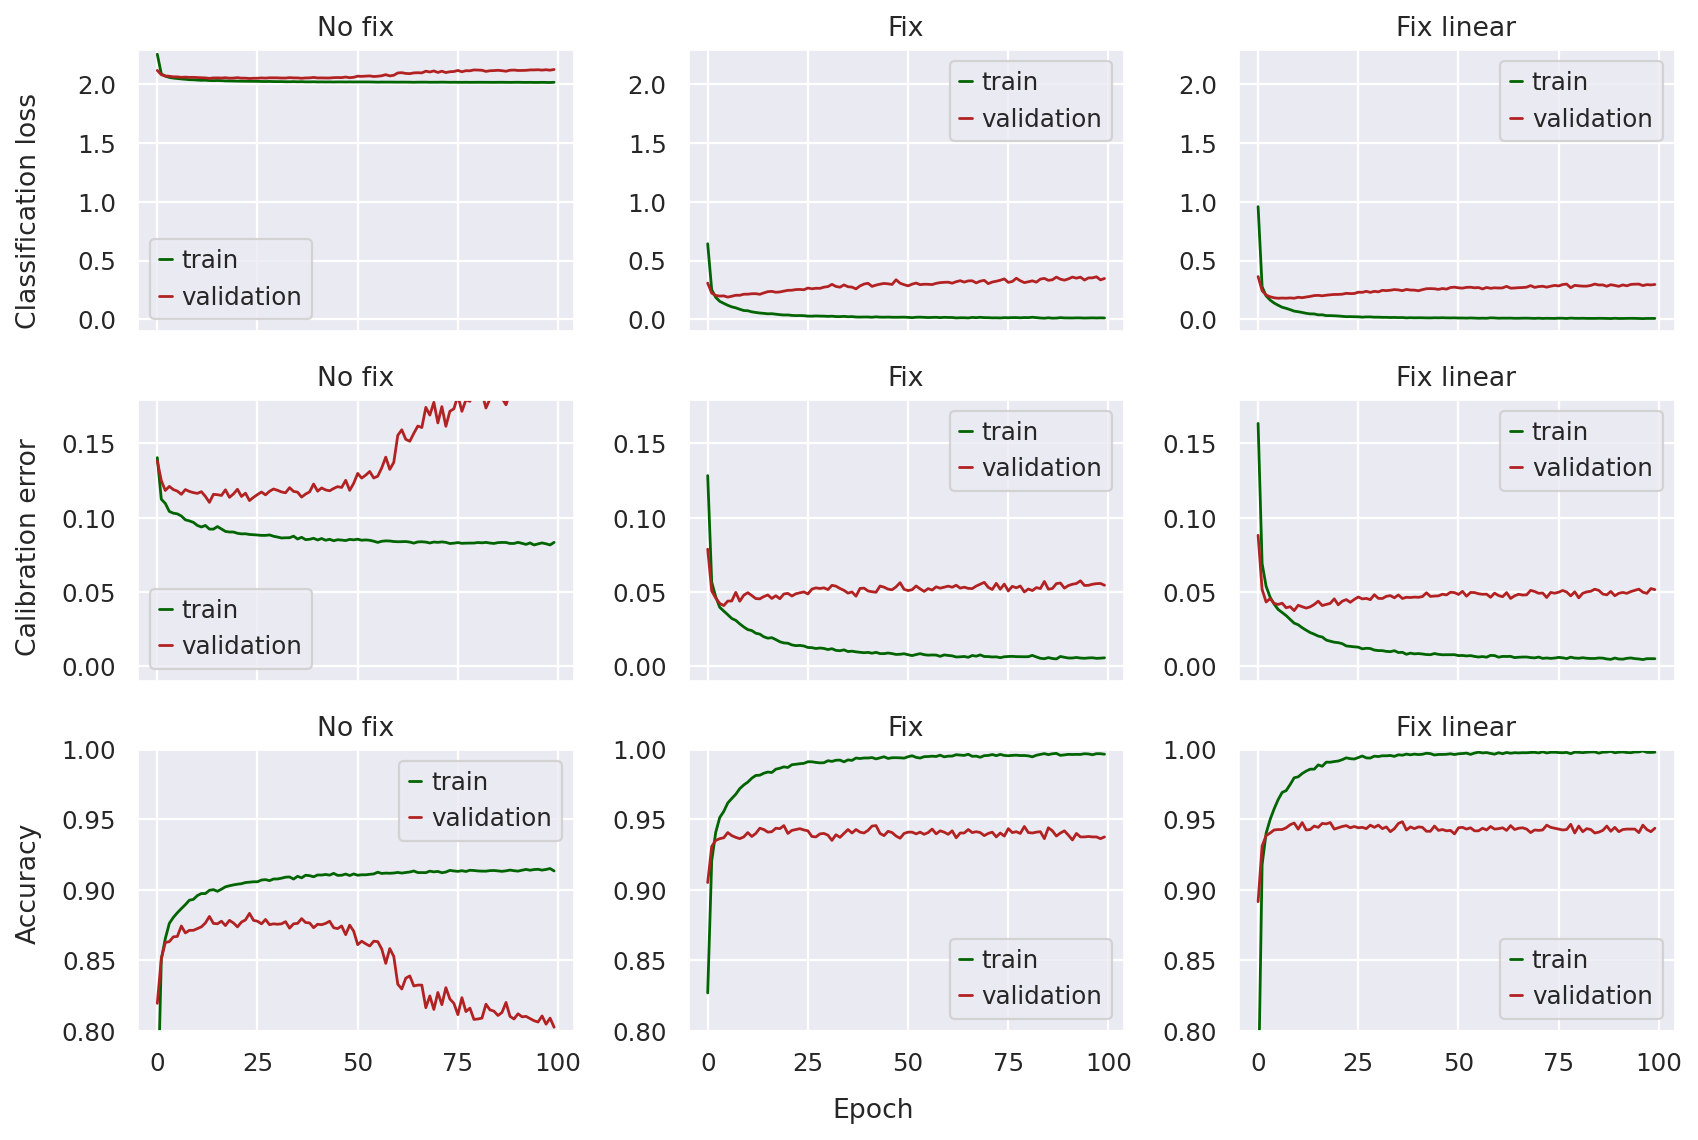

In [11]:
plot_classification_metrics(model_no_fix, model_fix, model_fix_linear)

Looking at the top row, we can immediately notice that the pre-fix model has a classification loss a magnitude larger than the other two (smaller is better). The curves don't seem as dramatic since the validation loss does not seem to diverge that much (*i.e.* the validation loss stays fairly close to the training loss), so we might incorrectly assume that the no fix model classifier is training with stability. 

However, once we take a look at the calibration error and accuracy, the problem is clear: in later epochs, these metrics increase (in the case of calibration error) or decrease (in the case of accuracy) sharply, indicating something wrong with model training.

This is not the case for the fixed models, where the classification loss is much lower throughout training, and both the calibration error and accuracy curves are much more stable. There does not seem to be too much of a difference between the fixed and fixed-linear model other than the linear one seeming a bit more "smooth".

## Plotting confusion matrices

Next, we plot confusion matrices for the validation observations. We are interested in just the validation split since the classifier will tend to overfit on the training set, so we'd like to see how it performs on unseen data.

In [12]:
def plot_confusion_matrices(
    model_no_fix: scvi.model.SCANVI,
    model_fix: scvi.model.SCANVI,
    model_fix_linear: scvi.model.SCANVI,
    subset: str | None = None,
    prediction_key: str = "_prediction",
    labels_key: str = "cell_type",
):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6.375), sharey=False, sharex=False)

    def plot_confusion_matrix(ax, model, title, subset):
        adata = model.adata
        adata.obs[prediction_key] = model.predict()

        if subset == "validation":
            adata = adata[model.validation_indices].copy()
        elif subset == "train":
            adata = adata[model.train_indices].copy()

        df = adata.obs.groupby([labels_key, prediction_key]).size().unstack(fill_value=0)
        conf_mat = df / df.sum(axis=1).values[:, np.newaxis]

        _ = ax.pcolor(conf_mat, cmap="cividis", vmin=0, vmax=1)
        _ = ax.set_xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
        _ = ax.set_yticks(np.arange(0.5, len(df.index), 1), df.index)
        ax.set_title(title)

    models = [model_no_fix, model_fix, model_fix_linear]
    model_names = ["No fix", "Fix", "Fix linear"]

    for model, model_name, ax in zip(models, model_names, axes, strict=False):
        plot_confusion_matrix(ax, model, model_name, subset)

    fig.text(0.0, 0.5, "Observed", va="center", rotation="vertical")
    fig.text(0.5, 0.0, "Predicted", ha="center")
    fig.tight_layout()

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/tmp/ipykernel_3463992/796943338.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata.obs.groupby([labels_key, prediction_key]).size().unstack(fill_value=0)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/tmp/ipykernel_3463992/796943338.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obser

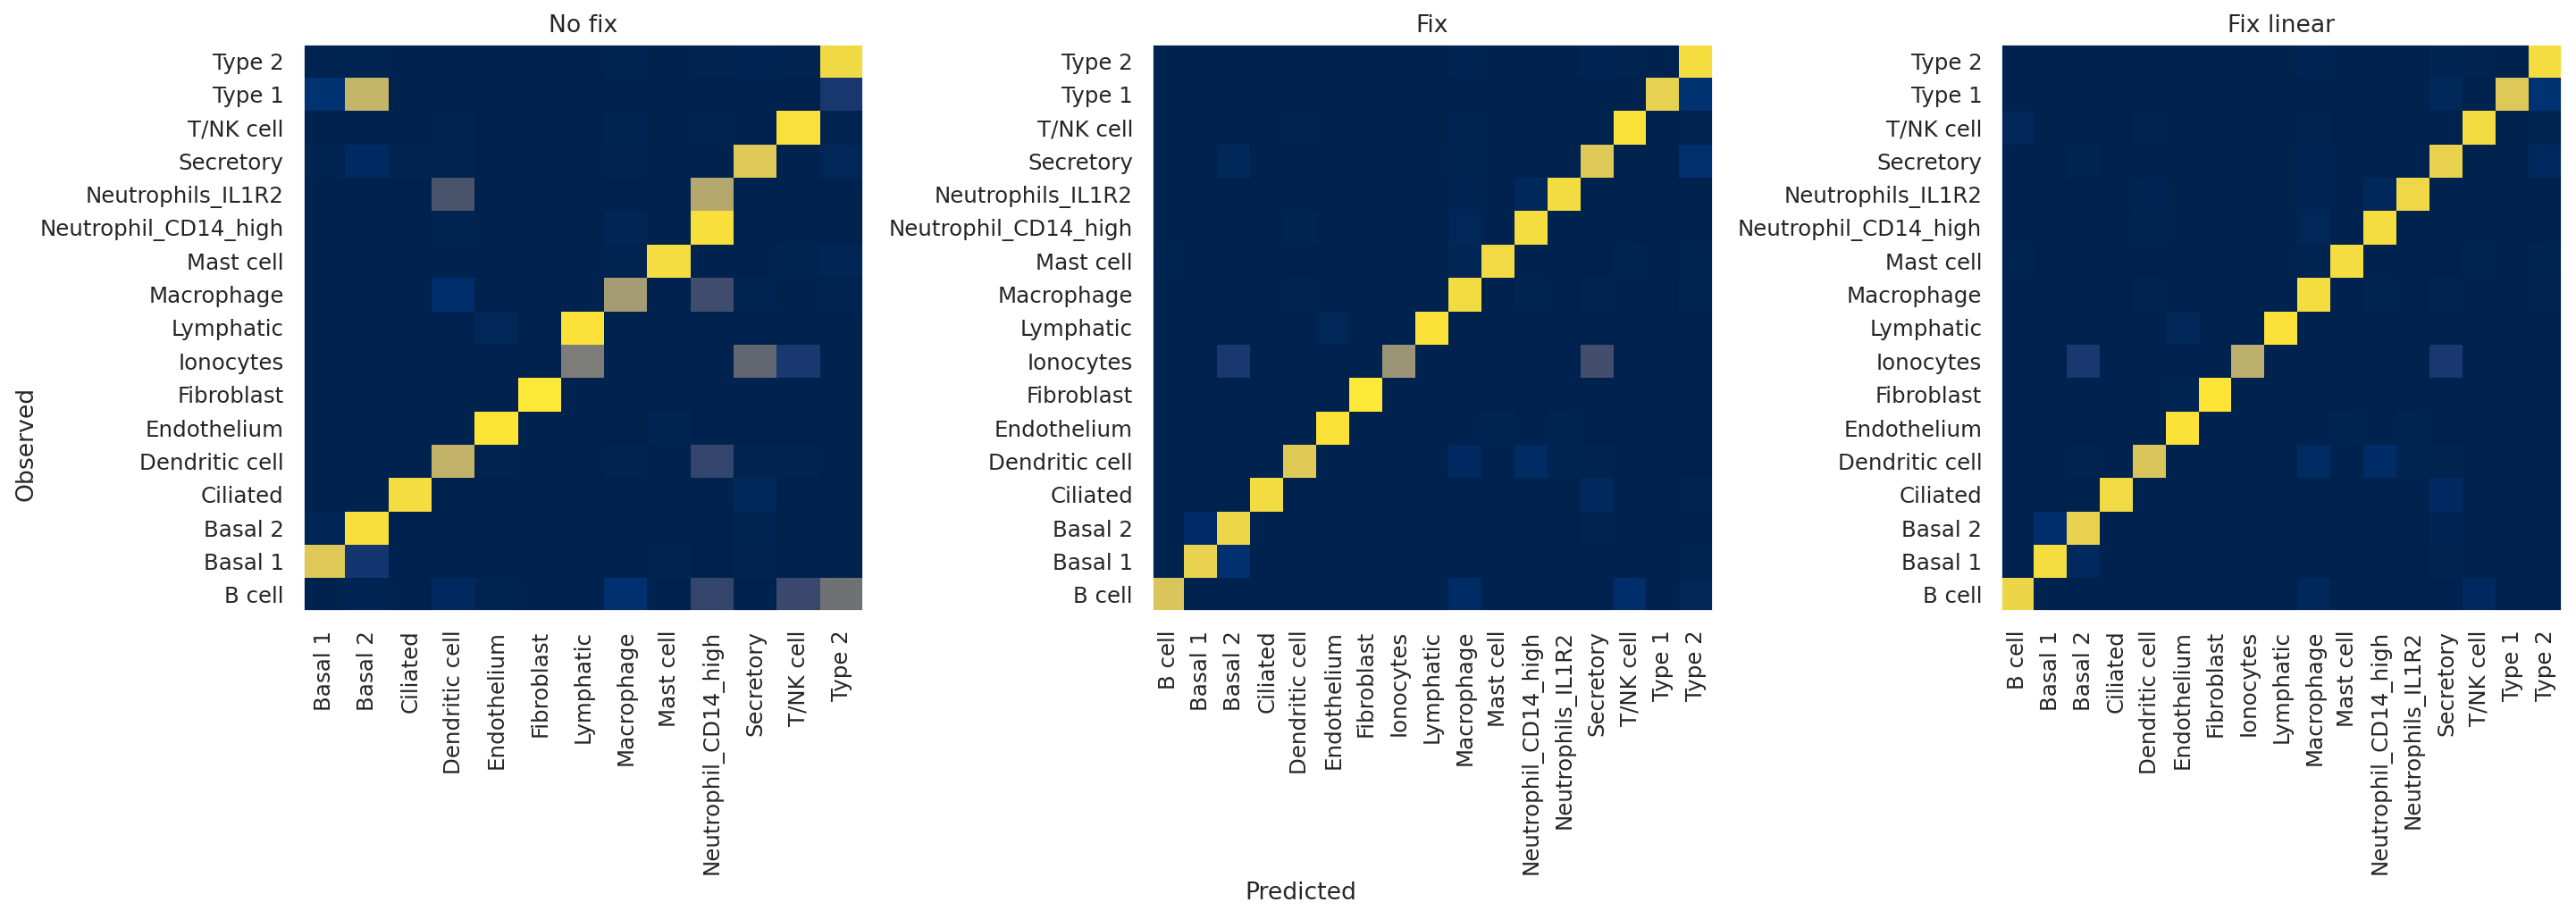

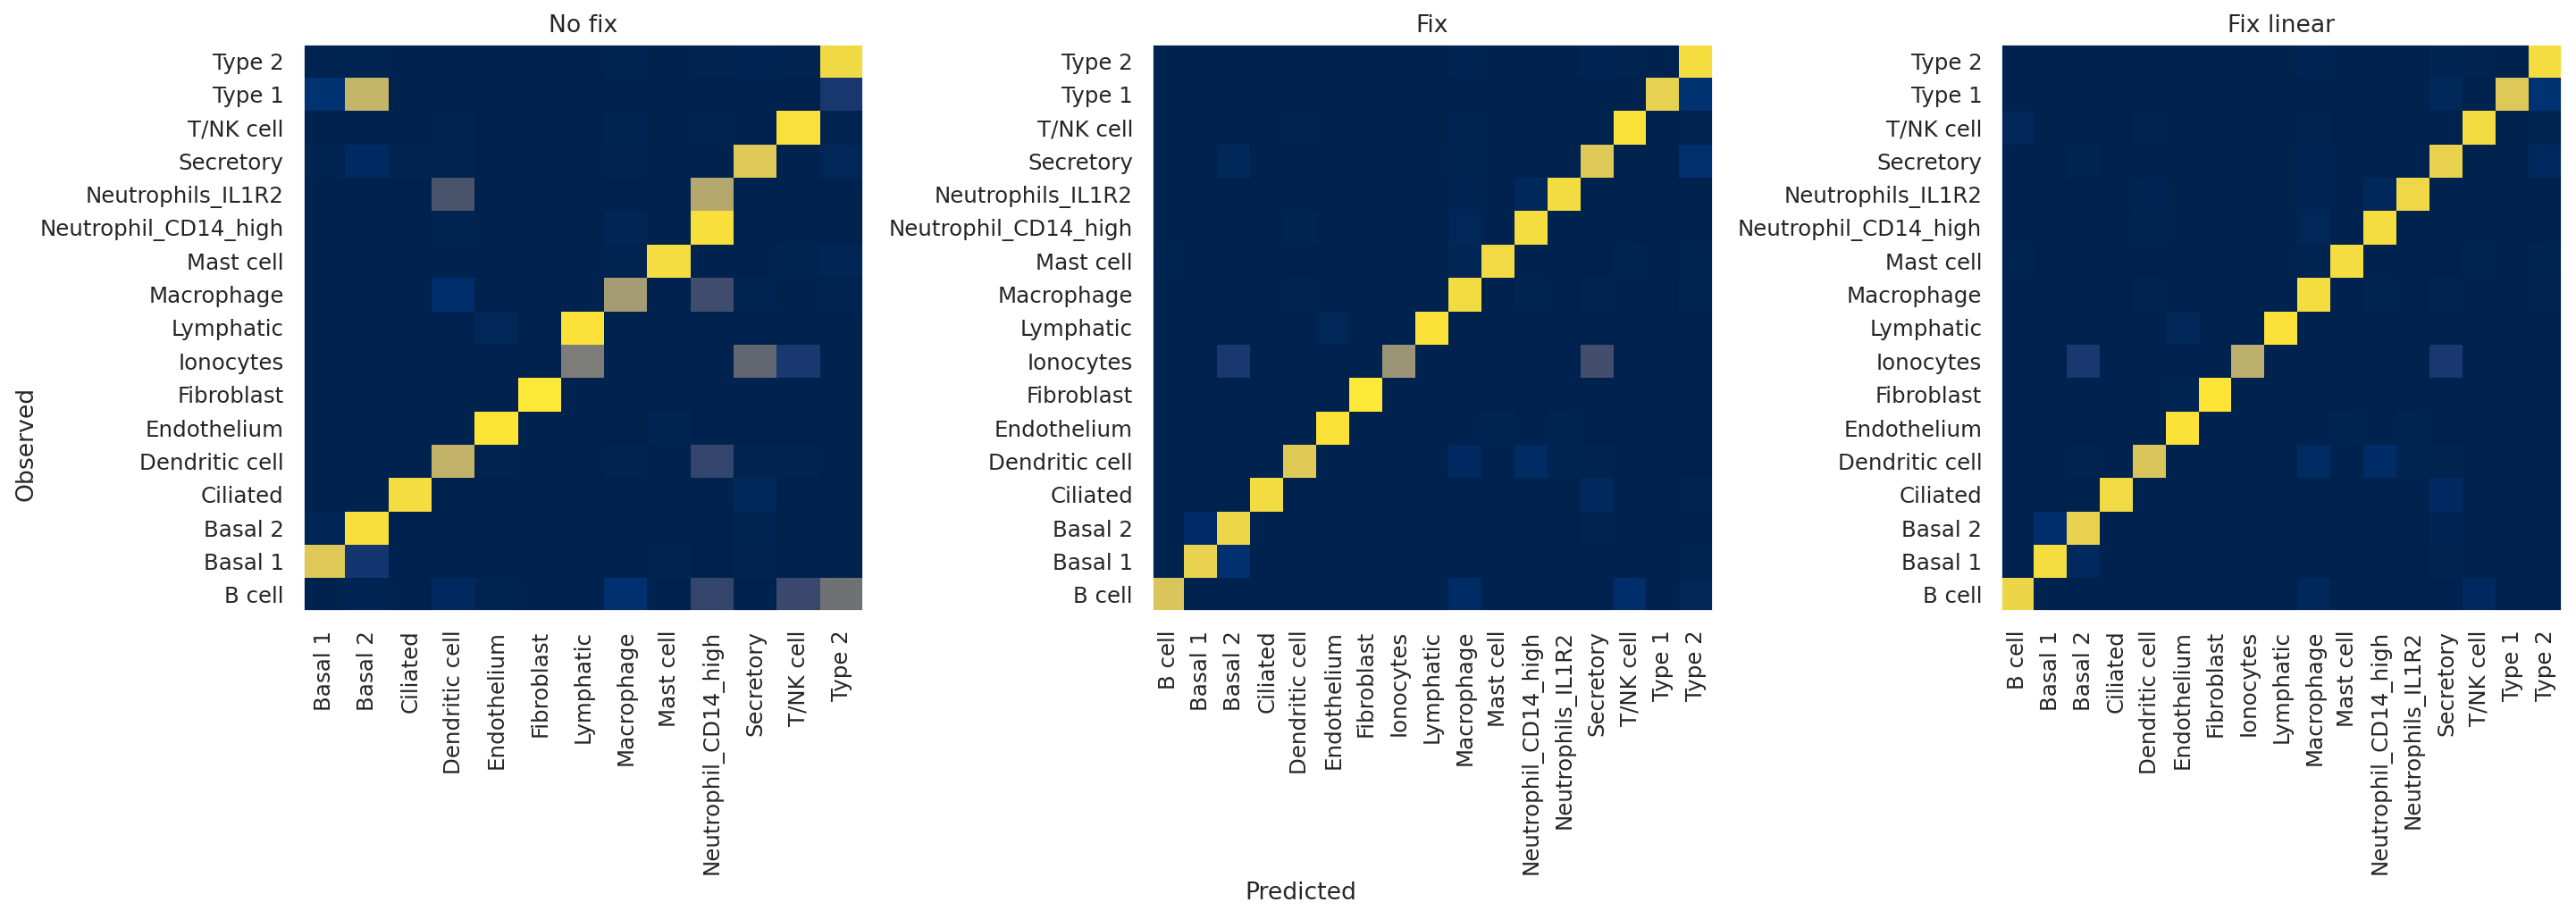

In [13]:
plot_confusion_matrices(model_no_fix, model_fix, model_fix_linear, subset="validation")

The x-axis indicates predicted labels, the y-axis observed labels, and the intensity of each square indicates the overlap between these two. In other words, if the square corresponding to "B cell observed" and "B cell predicted" has a value of 1 (bright yellow), this means that 100% of cells that the model classified as B cells have a ground truth label of B cells, and vice versa. A perfect classifier, then, would only have values of 1 along the diagonal and 0 elsewhere.

Qualitatively, we can appreciate that the no fix model performs very poorly, with, for example, almost no B cells being predicted by the model. On the other hand, the two fixed models seem to be performing well, with only slight differences between the two.

## Visualizing the embeddings

Visualizing the embeddings using UMAPS can be another useful qualitative check for evaluating how informative the model embeddings are of cell-type variability as well as batch integration performance.

In [14]:
def plot_latent_umaps(
    model_no_fix: scvi.model.SCANVI,
    model_fix: scvi.model.SCANVI,
    model_fix_linear: scvi.model.SCANVI,
    color: list | str | None = None,
    subset: str | None = None,
    latent_key: str = "_latent",
):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 3), sharey=False, sharex=False)

    def plot_latent_umap(ax, model, title, subset, legend_loc):
        adata = model.adata
        adata.obsm[latent_key] = model.get_latent_representation()
        sc.pp.neighbors(adata, use_rep=latent_key)

        if subset == "validation":
            adata = model.adata[model.validation_indices].copy()
        elif subset == "train":
            adata = model.adata[model.train_indices].copy()

        sc.tl.umap(adata, min_dist=0.3)
        sc.pl.umap(
            adata,
            color=color,
            frameon=False,
            ncols=1,
            ax=ax,
            show=False,
            legend_loc=legend_loc,
        )
        ax.set_title(title)

    models = [model_no_fix, model_fix, model_fix_linear]
    model_names = ["No fix", "Fix", "Fix linear"]
    legend_loc = ["none", "none", "right margin"]

    for model, model_name, ax, leg_loc in zip(models, model_names, axes, legend_loc, strict=False):
        plot_latent_umap(ax, model, model_name, subset, leg_loc)

    fig.text(0.0, 0.5, "UMAP_2", va="center", rotation="vertical")
    fig.text(0.5, 0.0, "UMAP_1", ha="center")
    fig.tight_layout()

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


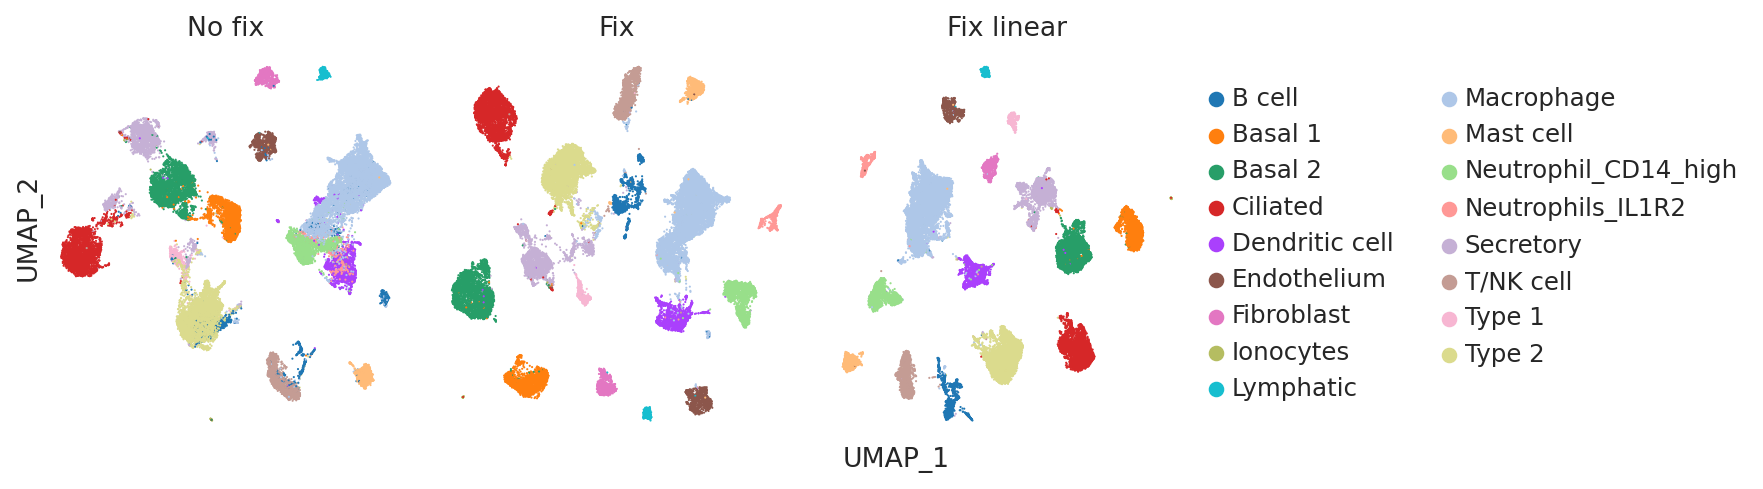

In [15]:
plot_latent_umaps(model_no_fix, model_fix, model_fix_linear, color="cell_type")

Once again, visually inspecting the embeddings confirms that the no fix model suffers from poor cell type identification (*e.g.* B cells and Type 2 cells are poorly separated).

## Comparing integration metrics

Finally, we can compute various integration metrics on the model embeddings to quantitatively assess their performance on biological conservation and batch integration. We rely on the [scib-metrics](https://scib-metrics.readthedocs.io/en/stable/) package for this. We start by computing the latent representations of each of these models.

In [17]:
X_SCVI_KEY = "X_scvi"
X_SCANVI_NO_FIX_KEY = "X_scanvi_no_fix"
X_SCANVI_FIX_KEY = "X_scanvi_fix"
X_SCANVI_FIX_LINEAR_KEY = "X_scanvi_fix_linear"

adata.obsm[X_SCVI_KEY] = scvi_model.get_latent_representation()
adata.obsm[X_SCANVI_NO_FIX_KEY] = model_no_fix.get_latent_representation()
adata.obsm[X_SCANVI_FIX_KEY] = model_fix.get_latent_representation()
adata.obsm[X_SCANVI_FIX_LINEAR_KEY] = model_fix_linear.get_latent_representation()

/usr/local/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


/usr/local/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


/usr/local/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [18]:
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=[
        "X_pca",
        X_SCVI_KEY,
        X_SCANVI_NO_FIX_KEY,
        X_SCANVI_FIX_KEY,
        X_SCANVI_FIX_LINEAR_KEY,
    ],
    n_jobs=-1,
)
bm.benchmark()

/usr/local/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)



Computing neighbors:   0%|          | 0/5 [00:00<?, ?it/s]


Computing neighbors:  20%|██        | 1/5 [00:06<00:24,  6.20s/it]


Computing neighbors:  40%|████      | 2/5 [00:11<00:17,  5.71s/it]


Computing neighbors:  60%|██████    | 3/5 [00:17<00:11,  5.68s/it]


Computing neighbors:  80%|████████  | 4/5 [00:22<00:05,  5.70s/it]


Computing neighbors: 100%|██████████| 5/5 [00:28<00:00,  5.72s/it]


Computing neighbors: 100%|██████████| 5/5 [00:28<00:00,  5.74s/it]


Embeddings:   0%|          | 0/5 [00:00<?, ?it/s]


Metrics:   0%|          | 0/10 [00:00<?, ?it/s]


Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]

2024-09-23 18:56:03.550768: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.68. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.



Metrics:  10%|█         | 1/10 [00:26<03:54, 26.09s/it, Bio conservation: isolated_labels]


Metrics:  10%|█         | 1/10 [00:26<03:54, 26.09s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]


Metrics:  20%|██        | 2/10 [00:27<01:33, 11.63s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]


Metrics:  20%|██        | 2/10 [00:27<01:33, 11.63s/it, Bio conservation: silhouette_label]             


Metrics:  30%|███       | 3/10 [00:53<02:05, 17.98s/it, Bio conservation: silhouette_label]


Metrics:  30%|███       | 3/10 [00:53<02:05, 17.98s/it, Bio conservation: clisi_knn]       


Metrics:  40%|████      | 4/10 [01:11<01:47, 17.99s/it, Bio conservation: clisi_knn]


Metrics:  40%|████      | 4/10 [01:11<01:47, 17.99s/it, Batch correction: silhouette_batch]


Metrics:  50%|█████     | 5/10 [01:22<01:17, 15.54s/it, Batch correction: silhouette_batch]


Metrics:  50%|█████     | 5/10 [01:22<01:17, 15.54s/it, Batch correction: ilisi_knn]       


Metrics:  60%|██████    | 6/10 [01:39<01:04, 16.22s/it, Batch correction: ilisi_knn]


Metrics:  60%|██████    | 6/10 [01:39<01:04, 16.22s/it, Batch correction: kbet_per_label]

/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)



Metrics:  70%|███████   | 7/10 [01:54<00:46, 15.55s/it, Batch correction: kbet_per_label]


Metrics:  70%|███████   | 7/10 [01:54<00:46, 15.55s/it, Batch correction: graph_connectivity]

/usr/local/lib/python3.12/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)




Metrics:  80%|████████  | 8/10 [01:54<00:31, 15.55s/it, Batch correction: pcr_comparison]    


Metrics:  90%|█████████ | 9/10 [01:54<00:08,  8.12s/it, Batch correction: pcr_comparison]


Embeddings:  20%|██        | 1/5 [01:54<07:37, 114.39s/it]


Metrics:   0%|          | 0/10 [00:00<?, ?it/s]


Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]


Metrics:  10%|█         | 1/10 [00:25<03:50, 25.60s/it, Bio conservation: isolated_labels]


Metrics:  10%|█         | 1/10 [00:25<03:50, 25.60s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]


Metrics:  20%|██        | 2/10 [00:27<01:31, 11.38s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]


Metrics:  20%|██        | 2/10 [00:27<01:31, 11.38s/it, Bio conservation: silhouette_label]             


Metrics:  30%|███       | 3/10 [00:52<02:04, 17.75s/it, Bio conservation: silhouette_label]


Metrics:  30%|███       | 3/10 [00:52<02:04, 17.75s/it, Bio conservation: clisi_knn]       


Metrics:  40%|████      | 4/10 [01:09<01:45, 17.64s/it, Bio conservation: clisi_knn]


Metrics:  40%|████      | 4/10 [01:09<01:45, 17.64s/it, Batch correction: silhouette_batch]


Metrics:  50%|█████     | 5/10 [01:14<01:04, 12.85s/it, Batch correction: silhouette_batch]


Metrics:  50%|█████     | 5/10 [01:14<01:04, 12.85s/it, Batch correction: ilisi_knn]       


Metrics:  60%|██████    | 6/10 [01:31<00:57, 14.42s/it, Batch correction: ilisi_knn]


Metrics:  60%|██████    | 6/10 [01:31<00:57, 14.42s/it, Batch correction: kbet_per_label]

/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)



Metrics:  70%|███████   | 7/10 [01:44<00:41, 13.80s/it, Batch correction: kbet_per_label]


Metrics:  70%|███████   | 7/10 [01:44<00:41, 13.80s/it, Batch correction: graph_connectivity]

/usr/local/lib/python3.12/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)




Metrics:  80%|████████  | 8/10 [01:44<00:27, 13.80s/it, Batch correction: pcr_comparison]    


Metrics:  90%|█████████ | 9/10 [01:44<00:07,  7.20s/it, Batch correction: pcr_comparison]


Embeddings:  40%|████      | 2/5 [03:38<05:25, 108.53s/it]


Metrics:   0%|          | 0/10 [00:00<?, ?it/s]


Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]


Metrics:  10%|█         | 1/10 [00:25<03:48, 25.43s/it, Bio conservation: isolated_labels]


Metrics:  10%|█         | 1/10 [00:25<03:48, 25.43s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]


Metrics:  20%|██        | 2/10 [00:26<01:29, 11.25s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]


Metrics:  20%|██        | 2/10 [00:26<01:29, 11.25s/it, Bio conservation: silhouette_label]             


Metrics:  30%|███       | 3/10 [00:52<02:04, 17.78s/it, Bio conservation: silhouette_label]


Metrics:  30%|███       | 3/10 [00:52<02:04, 17.78s/it, Bio conservation: clisi_knn]       


Metrics:  40%|████      | 4/10 [01:09<01:45, 17.65s/it, Bio conservation: clisi_knn]


Metrics:  40%|████      | 4/10 [01:09<01:45, 17.65s/it, Batch correction: silhouette_batch]


Metrics:  50%|█████     | 5/10 [01:12<01:02, 12.43s/it, Batch correction: silhouette_batch]


Metrics:  50%|█████     | 5/10 [01:12<01:02, 12.43s/it, Batch correction: ilisi_knn]       


Metrics:  60%|██████    | 6/10 [01:30<00:56, 14.14s/it, Batch correction: ilisi_knn]


Metrics:  60%|██████    | 6/10 [01:30<00:56, 14.14s/it, Batch correction: kbet_per_label]

/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)



Metrics:  70%|███████   | 7/10 [01:41<00:39, 13.21s/it, Batch correction: kbet_per_label]


Metrics:  70%|███████   | 7/10 [01:41<00:39, 13.21s/it, Batch correction: graph_connectivity]

/usr/local/lib/python3.12/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)




Metrics:  80%|████████  | 8/10 [01:41<00:26, 13.21s/it, Batch correction: pcr_comparison]    


Embeddings:  60%|██████    | 3/5 [05:20<03:30, 105.43s/it]


Metrics:   0%|          | 0/10 [00:00<?, ?it/s]


Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]


Metrics:  10%|█         | 1/10 [00:25<03:48, 25.43s/it, Bio conservation: isolated_labels]


Metrics:  10%|█         | 1/10 [00:25<03:48, 25.43s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]


Metrics:  20%|██        | 2/10 [00:26<01:29, 11.25s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]


Metrics:  20%|██        | 2/10 [00:26<01:29, 11.25s/it, Bio conservation: silhouette_label]             


Metrics:  30%|███       | 3/10 [00:52<02:04, 17.78s/it, Bio conservation: silhouette_label]


Metrics:  30%|███       | 3/10 [00:52<02:04, 17.78s/it, Bio conservation: clisi_knn]       


Metrics:  40%|████      | 4/10 [01:09<01:45, 17.65s/it, Bio conservation: clisi_knn]


Metrics:  40%|████      | 4/10 [01:09<01:45, 17.65s/it, Batch correction: silhouette_batch]


Metrics:  50%|█████     | 5/10 [01:12<01:02, 12.43s/it, Batch correction: silhouette_batch]


Metrics:  50%|█████     | 5/10 [01:12<01:02, 12.43s/it, Batch correction: ilisi_knn]       


Metrics:  60%|██████    | 6/10 [01:30<00:56, 14.14s/it, Batch correction: ilisi_knn]


Metrics:  60%|██████    | 6/10 [01:30<00:56, 14.14s/it, Batch correction: kbet_per_label]

/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)



Metrics:  70%|███████   | 7/10 [01:41<00:39, 13.13s/it, Batch correction: kbet_per_label]


Metrics:  70%|███████   | 7/10 [01:41<00:39, 13.13s/it, Batch correction: graph_connectivity]

/usr/local/lib/python3.12/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)




Metrics:  80%|████████  | 8/10 [01:41<00:26, 13.13s/it, Batch correction: pcr_comparison]    


Embeddings:  80%|████████  | 4/5 [07:02<01:43, 103.87s/it]


Metrics:   0%|          | 0/10 [00:00<?, ?it/s]


Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]


Metrics:  10%|█         | 1/10 [00:25<03:48, 25.43s/it, Bio conservation: isolated_labels]


Metrics:  10%|█         | 1/10 [00:25<03:48, 25.43s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]


Metrics:  20%|██        | 2/10 [00:26<01:29, 11.25s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]


Metrics:  20%|██        | 2/10 [00:26<01:29, 11.25s/it, Bio conservation: silhouette_label]             


Metrics:  30%|███       | 3/10 [00:52<02:04, 17.78s/it, Bio conservation: silhouette_label]


Metrics:  30%|███       | 3/10 [00:52<02:04, 17.78s/it, Bio conservation: clisi_knn]       


Metrics:  40%|████      | 4/10 [01:09<01:45, 17.66s/it, Bio conservation: clisi_knn]


Metrics:  40%|████      | 4/10 [01:09<01:45, 17.66s/it, Batch correction: silhouette_batch]


Metrics:  50%|█████     | 5/10 [01:12<01:02, 12.43s/it, Batch correction: silhouette_batch]


Metrics:  50%|█████     | 5/10 [01:12<01:02, 12.43s/it, Batch correction: ilisi_knn]       


Metrics:  60%|██████    | 6/10 [01:30<00:56, 14.14s/it, Batch correction: ilisi_knn]


Metrics:  60%|██████    | 6/10 [01:30<00:56, 14.14s/it, Batch correction: kbet_per_label]

/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)



Metrics:  70%|███████   | 7/10 [01:41<00:39, 13.06s/it, Batch correction: kbet_per_label]


Metrics:  70%|███████   | 7/10 [01:41<00:39, 13.06s/it, Batch correction: graph_connectivity]

/usr/local/lib/python3.12/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)




Metrics:  80%|████████  | 8/10 [01:41<00:26, 13.06s/it, Batch correction: pcr_comparison]    


Embeddings: 100%|██████████| 5/5 [08:43<00:00, 102.94s/it]


Embeddings: 100%|██████████| 5/5 [08:43<00:00, 104.67s/it]

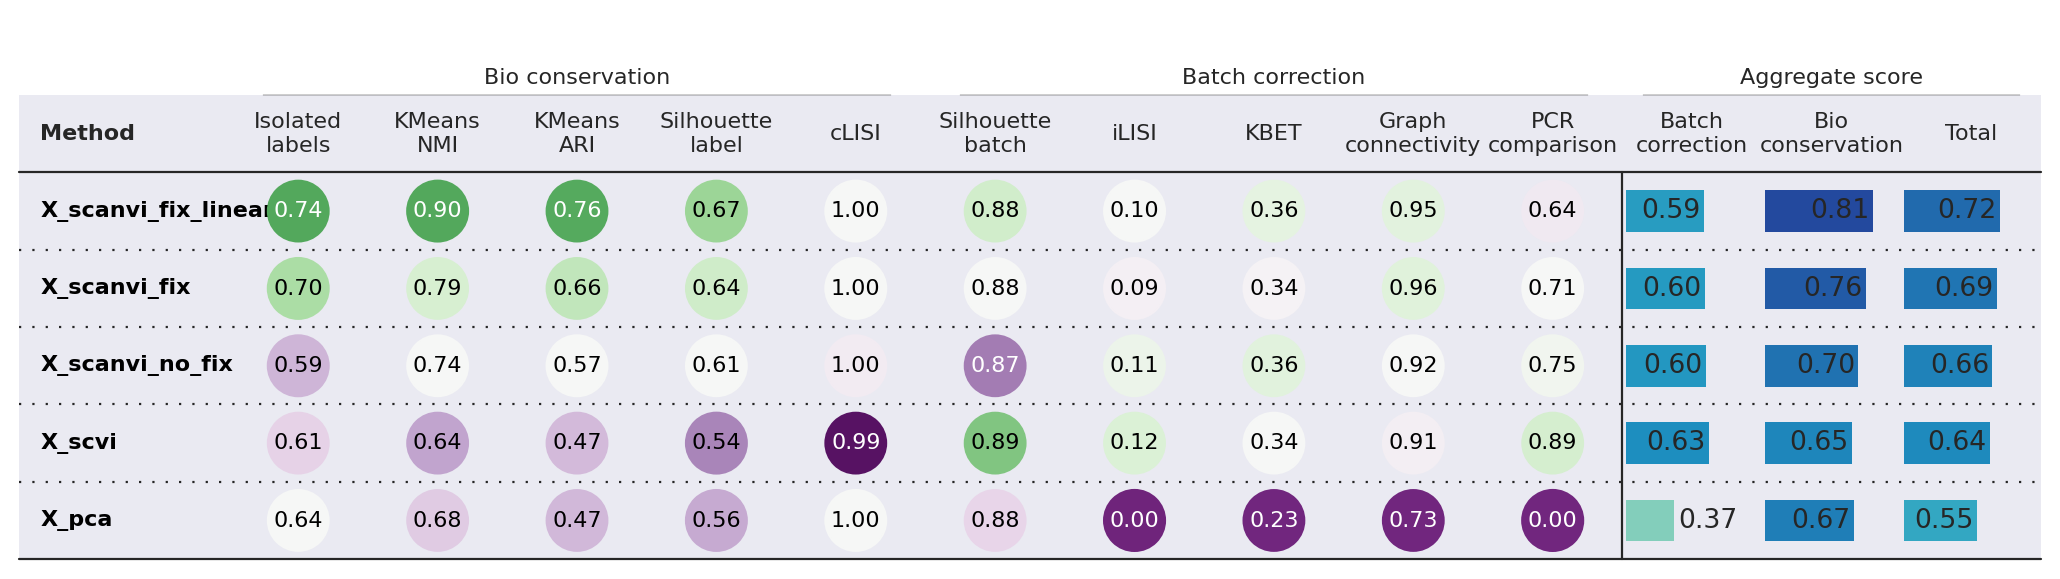

In [19]:
bm.plot_results_table(min_max_scale=False)

While batch integration performance seems to degrade slightly from the pre-fix to fixed models, the difference is very small compared to the increased performance in bio-conservation. Particularly, we note a noticeable increase with using the linear classifier.